In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

# ===== 1. Define the Graph =====
edges = [
    ("A", "B"),
    ("B", "A"),
    ("B", "C"),
    ("B", "D"),
    ("B", "E"),
    ("C", "B"),
    ("C", "E"),
    ("D", "B"),
    ("E", "B"),
    ("E", "C"),
    ("E", "F"),
    ("F", "E")
]

nodes = sorted(set(sum(edges, ())))  # ['A', 'B', 'C', 'D', 'E', 'F']

# ===== 2. Functions for Matrices =====

def plot_graph(edges):
    G = nx.Graph()
    G.add_edges_from(edges)

    plt.figure(figsize=(6, 6))
    nx.draw(G, with_labels=True, node_color="skyblue", node_size=2000, edge_color="gray", font_size=12, font_family="Arial")
    plt.title("Nodes Network")
    plt.show()

def get_adjacency_matrix(edges, nodes):
    adj = pd.DataFrame(0, index=nodes, columns=nodes)
    for a, b in edges:
        adj.at[a, b] = 1
    return adj

def get_degree_matrix(adj):
    deg = pd.DataFrame(0, index=adj.index, columns=adj.columns)
    for node in adj.index:
        degree = adj.loc[node].sum()
        deg.at[node, node] = degree
    return deg

def get_feature_matrix():
    features = torch.tensor([
        [1.0, 0.0],  # A
        [0.0, 1.0],  # B
        [1.0, 1.0],  # C
        [0.5, 1.5],  # D
        [1.5, 0.5],  # E
        [2.0, 1.0]   # F
    ], dtype=torch.float32)
    features_df = pd.DataFrame(features.numpy(), index=nodes, columns=["Feature1", "Feature2"])
    return features_df

# ===== 3. Calculate Basic Matrices =====

adj_matrix = get_adjacency_matrix(edges, nodes)
degree_matrix = get_degree_matrix(adj_matrix)
feature_matrix = get_feature_matrix()

print("\n--- Adjacency Matrix ---")
print(adj_matrix)

print("\n--- Degree Matrix ---")
print(degree_matrix)

print("\n--- Feature Matrix ---")
print(feature_matrix)




--- Adjacency Matrix ---
   A  B  C  D  E  F
A  0  1  0  0  0  0
B  1  0  1  1  1  0
C  0  1  0  0  1  0
D  0  1  0  0  0  0
E  0  1  1  0  0  1
F  0  0  0  0  1  0

--- Degree Matrix ---
   A  B  C  D  E  F
A  1  0  0  0  0  0
B  0  4  0  0  0  0
C  0  0  2  0  0  0
D  0  0  0  1  0  0
E  0  0  0  0  3  0
F  0  0  0  0  0  1

--- Feature Matrix ---
   Feature1  Feature2
A       1.0       0.0
B       0.0       1.0
C       1.0       1.0
D       0.5       1.5
E       1.5       0.5
F       2.0       1.0


Nodes in a graph have varying degrees (number of connections), meaning nodes with higher degrees can disproportionately influence the learning process. Normalizing the adjacency matrix ensures that each node contributes equally to feature propagation, regardless of its degree. This prevents high-degree nodes from dominating, stabilizes training, and ensures fair influence across all nodes, making the graph convolution process more effective and balanced.

The formula is:

$\hat A = D^{-1/2} A D^{-1/2}$

Where:
- $D^{-1/2}$ is the degree matrix with inverse square roots of degrees.

## Step-by-Step Calculation

### Step 1: Find $D^{-1/2}$

Take each degree value 𝑑 from 𝐷 and compute $d^{-1/2}$.

| Node | Degree 𝑑 | $d^{-1/2}$|
|------|---------|-----------|
| A    | 1       | 1.0       |
| B    | 4       | 0.5       |
| C    | 2       | 0.7071    |
| D    | 1       | 1.0       |
| E    | 3       | 0.5774    |
| F    | 1       | 1.0       |

Thus:

$D^{-1/2}$ = diag(1.0, 0.5, 0.7071, 1.0, 0.5774, 1.0)

### Step 2: Multiply

Each element of $\hat A_{ij}$ is calculated as:

$\hat A_{ij} = A_{ij} \times D_{ii}^{-1/2} \times  D_{jj}^{-1/2}$

Examples:
- $\hat A_{AB}$ = 1 × 1.0 × 0.5 = 0.5
- $\hat A_{BC}$ = 1 × 0.5 × 0.7071 ≈ 0.3536
- $\hat A_{EF}$ = 1 × 0.5774 × 1.0 = 0.5774

If $A_{ij}$ = 0, then $\hat A_{ij}$ = 0.


--- Normalized Adjacency Matrix ---
     A         B         C    D         E        F
A  0.0  0.500000  0.000000  0.0  0.000000  0.00000
B  0.5  0.000000  0.353553  0.5  0.288675  0.00000
C  0.0  0.353553  0.000000  0.0  0.408248  0.00000
D  0.0  0.500000  0.000000  0.0  0.000000  0.00000
E  0.0  0.288675  0.408248  0.0  0.000000  0.57735
F  0.0  0.000000  0.000000  0.0  0.577350  0.00000

--- Weight Matrix W ---
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380]])

--- First GCN Layer Output (H^(1)) ---
          0         1         2         3
A -0.418568 -0.503066  0.201673  0.419013
B  1.014477 -0.888771 -0.941838  1.919198
C  0.338850 -0.616974 -0.670208  0.815440
D -0.418568 -0.503066  0.201673  0.419013
E  1.026520 -0.893627 -0.944499  1.956304
F  1.021467 -0.482040 -0.829744  0.734193


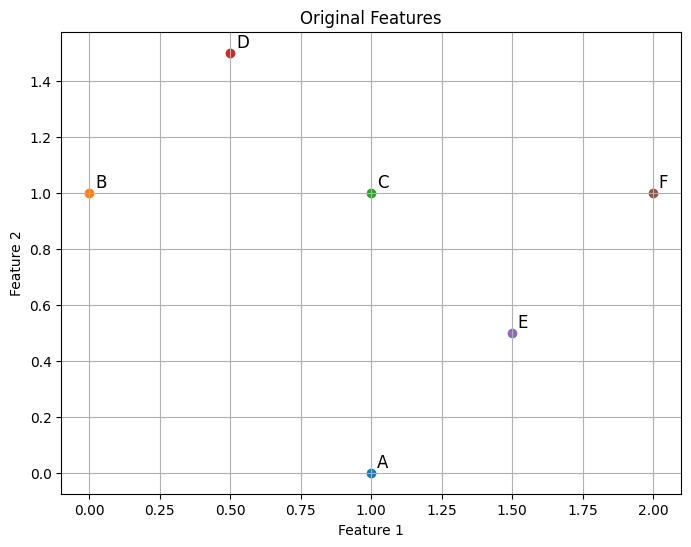

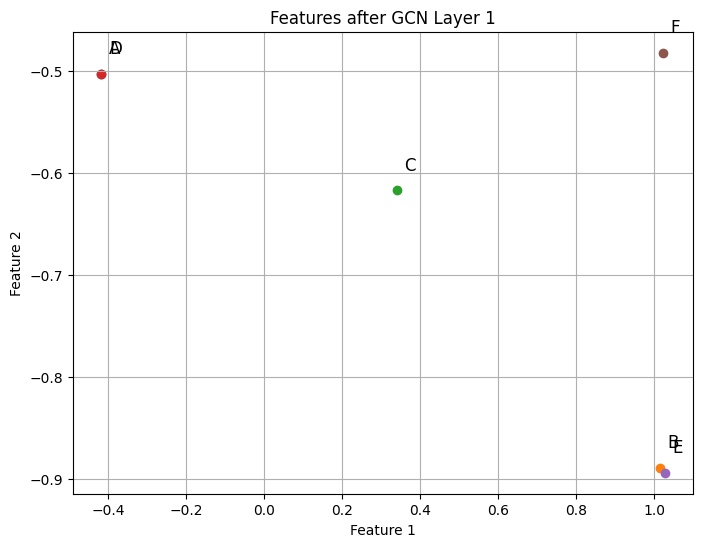

In [16]:
# ===== 4. Calculate Normalized Adjacency =====

def normalize_adjacency(adj):
    adj = torch.tensor(adj.values, dtype=torch.float32)
    deg = adj.sum(dim=1)  # Degree vector
    deg_inv_sqrt = torch.pow(deg, -0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0  # Handle isolated nodes
    D_inv_sqrt = torch.diag(deg_inv_sqrt)
    adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
    return adj_normalized

norm_adj = normalize_adjacency(adj_matrix)
print("\n--- Normalized Adjacency Matrix ---")
print(pd.DataFrame(norm_adj.numpy(), index=nodes, columns=nodes))

# ===== 5. Define Weight Matrix =====

torch.manual_seed(0)  # For reproducibility
W = torch.randn((2, 4))  # (input_dim, output_dim), 2 -> 4
print("\n--- Weight Matrix W ---")
print(W)

# ===== 6. GCN Forward Step =====

X = torch.tensor(feature_matrix.values, dtype=torch.float32)
AX = norm_adj @ X
AXW = AX @ W
H1 = F.elu(AXW)

print("\n--- First GCN Layer Output (H^(1)) ---")
print(pd.DataFrame(H1.detach().numpy(), index=nodes))

# ===== 7. Visualize Feature Updates =====

def plot_features(features, title):
    features = features.detach().numpy()
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(nodes):
        plt.scatter(features[i, 0], features[i, 1])
        plt.text(features[i, 0] + 0.02, features[i, 1] + 0.02, label, fontsize=12)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_features(X, "Original Features")
plot_features(H1, "Features after GCN Layer 1")

tensor([[0.8365, 0.9175],
        [1.9562, 2.0139],
        [1.2874, 1.4129],
        [0.8365, 0.9175],
        [0.9760, 1.0916],
        [0.9841, 1.0807]])


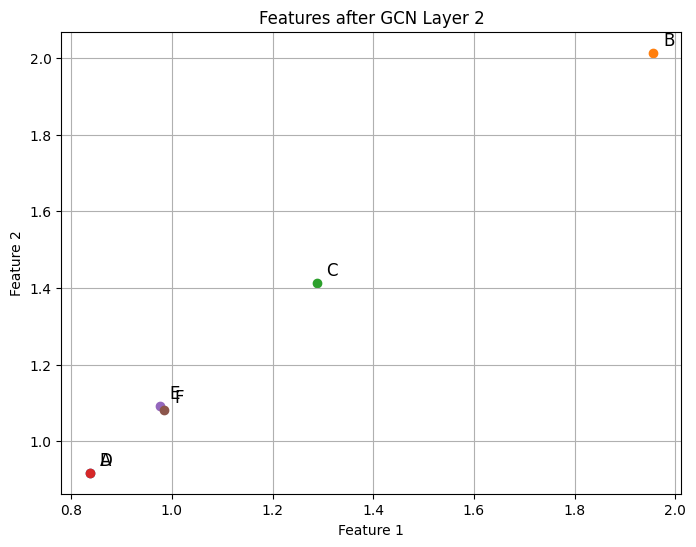

In [18]:
# GCN Layer 2
W2 = torch.randn((4, 2))  # Next layer weight
AXW2 = norm_adj @ H1 @ W2
H2 = F.relu(AXW2)
print(H2)
plot_features(H2, "Features after GCN Layer 2")
